In [3]:
import sys
import subprocess

def install_package(package_name):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])

install_package("pandas")

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [14]:
import sys

!{sys.executable} -m pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [5]:
"""
Assignment 3: Prompt Engineering Lab with Local Models (Ollama + LLaMA 3.2 1B)
Submitted by: Lasit Vyas
"""

import json
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from dataclasses import dataclass, asdict
from typing import List, Dict

# ============================================================================
# Setup
# ============================================================================

RESULTS_DIR = "a3_outputs"
os.makedirs(RESULTS_DIR, exist_ok=True)
MODEL = "llama3.2:1b"

def ollama_run(model: str, prompt: str, timeout: int = 120) -> str:
    """Run a prompt through Ollama and return response."""
    cmd = ["ollama", "run", model]
    try:
        proc = subprocess.run(
            cmd, 
            input=prompt.encode("utf-8"), 
            stdout=subprocess.PIPE, 
            stderr=subprocess.PIPE, 
            timeout=timeout
        )
        if proc.returncode != 0:
            raise RuntimeError(f"Ollama error: {proc.stderr.decode('utf-8', errors='ignore')}")
        return proc.stdout.decode("utf-8", errors="ignore").strip()
    except Exception as e:
        return f"[ERROR] {str(e)}"

@dataclass
class Trial:
    step: str
    task_id: str
    prompt: str
    response: str
    meta: Dict

def save_trials(trials: List[Trial], path: str):
    with open(path, "w", encoding="utf-8") as f:
        json.dump([asdict(t) for t in trials], f, ensure_ascii=False, indent=2)
    print(f"Saved {len(trials)} trials to {path}")

# ============================================================================
# Context and Tasks
# ============================================================================

CONTEXT = """
NeuralCraft AI is a startup developing next-generation generative AI products for enterprise customers. 
The company's flagship platform includes three core modules: a large language model (LLM) fine-tuning service 
that allows businesses to customize models for domain-specific tasks, a multimodal AI assistant that processes 
text, images, and audio inputs to generate comprehensive responses, and an AI code generation tool 
that produces production-ready code from natural language specifications.

The platform utilizes transformer-based architectures with attention mechanisms, implements retrieval-augmented 
generation (RAG) to enhance factual accuracy, and employs reinforcement learning from human feedback (RLHF) 
to align model outputs with human preferences. Advanced safety measures include constitutional AI principles, 
content filtering systems, and bias detection algorithms to ensure responsible AI deployment.

Key performance metrics tracked include model inference latency (target <200ms), hallucination rates 
(measured through fact-checking benchmarks), user satisfaction scores from enterprise clients, and model 
accuracy on domain-specific evaluation datasets. The engineering team monitors GPU utilization rates, 
training convergence metrics, and API response times to optimize system performance and cost efficiency.
""".strip()

TASKS = [
    {"id": "t1", "question": "Explain the three core modules of NeuralCraft AI's platform and their primary functions."},
    {"id": "t2", "question": "Describe what RAG (Retrieval-Augmented Generation) is and why it's important for AI systems."},
    {"id": "t3", "question": "List the key performance metrics mentioned and explain why each metric is critical for an AI platform."},
    {"id": "t4", "question": "What is RLHF (Reinforcement Learning from Human Feedback) and how does it improve AI model alignment?"},
    {"id": "t5", "question": "Propose two strategies NeuralCraft AI could implement to reduce model hallucination rates."},
    {"id": "t6", "question": "Explain the role of transformer architectures and attention mechanisms in modern AI systems."},
]

print(f"Running experiment with {len(TASKS)} tasks using {MODEL}")

# ============================================================================
# Step 1: Basic Prompting
# ============================================================================

print("\n=== STEP 1: BASIC PROMPTING ===")
basic_trials = []

for i, task in enumerate(TASKS, 1):
    print(f"Processing task {i}/{len(TASKS)}: {task['id']}")
    
    prompt = f"""You are a helpful assistant.

Context:
{CONTEXT}

Question:
{task['question']}"""
    
    response = ollama_run(MODEL, prompt)
    basic_trials.append(Trial(
        step="basic", 
        task_id=task["id"], 
        prompt=prompt, 
        response=response, 
        meta={"approach": "direct_question"}
    ))

save_trials(basic_trials, os.path.join(RESULTS_DIR, "step1_basic.json"))

# ============================================================================
# Step 2: Structured Output Prompts
# ============================================================================

print("\n=== STEP 2: STRUCTURED OUTPUT PROMPTS ===")
structured_trials = []

for i, task in enumerate(TASKS, 1):
    print(f"Processing task {i}/{len(TASKS)}: {task['id']}")
    
    prompt = f"""You are a helpful assistant. You must return your answer in strict JSON format with the following structure:

{{
  "answer": "your main answer here",
  "supporting_facts": ["fact 1 from context", "fact 2 from context"],
  "confidence": 0.95
}}

Instructions:
- "answer": Provide a complete answer to the question
- "supporting_facts": List 2-3 specific facts from the context that support your answer
- "confidence": Rate your confidence from 0.0 to 1.0 based on how well the context supports your answer

Context:
{CONTEXT}

Question:
{task['question']}

Remember: Output ONLY valid JSON, no additional text."""
    
    response = ollama_run(MODEL, prompt)
    structured_trials.append(Trial(
        step="structured", 
        task_id=task["id"], 
        prompt=prompt, 
        response=response, 
        meta={"format": "json", "required_fields": ["answer", "supporting_facts", "confidence"]}
    ))

save_trials(structured_trials, os.path.join(RESULTS_DIR, "step2_structured.json"))

# ============================================================================
# Step 3: Few-shot Prompting
# ============================================================================

print("\n=== STEP 3: FEW-SHOT PROMPTING ===")

FEW_SHOT_EXAMPLES = [
    {
        "q": "What is constitutional AI and how does it relate to AI safety?",
        "a": "Constitutional AI is a method for training AI systems to follow a set of principles or 'constitution' that guides their behavior, helping ensure they provide helpful, harmless, and honest responses while avoiding potentially dangerous outputs."
    },
    {
        "q": "Why is model inference latency important for AI applications?",
        "a": "Model inference latency, the time it takes for an AI model to process input and generate output, is critical because it directly impacts user experience. High latency can make AI applications feel slow and unresponsive, reducing adoption and usability."
    },
    {
        "q": "What are transformer architectures in AI?",
        "a": "Transformer architectures are neural network designs that use attention mechanisms to process sequential data efficiently. They form the foundation of modern large language models like GPT and BERT, enabling these models to understand context and relationships in text."
    }
]

def create_fewshot_prompt(examples):
    parts = ["You are a helpful assistant. Here are some example questions and answers about AI and machine learning:"]
    for i, ex in enumerate(examples, 1):
        parts.append(f"Example {i}:")
        parts.append(f"Q: {ex['q']}")
        parts.append(f"A: {ex['a']}")
    parts.append("Now answer the following question using the same style and the provided context.")
    return "\n\n".join(parts)

fewshot_prefix = create_fewshot_prompt(FEW_SHOT_EXAMPLES)
fewshot_trials = []

for i, task in enumerate(TASKS, 1):
    print(f"Processing task {i}/{len(TASKS)}: {task['id']}")
    
    prompt = f"""{fewshot_prefix}

Context:
{CONTEXT}

Question:
{task['question']}

Answer:"""
    
    response = ollama_run(MODEL, prompt)
    fewshot_trials.append(Trial(
        step="fewshot", 
        task_id=task["id"], 
        prompt=prompt, 
        response=response, 
        meta={"k_shot": len(FEW_SHOT_EXAMPLES), "example_domains": ["constitutional_ai", "latency", "transformers"]}
    ))

save_trials(fewshot_trials, os.path.join(RESULTS_DIR, "step3_fewshot.json"))

# ============================================================================
# Step 4: Chain-of-Thought (CoT) Prompting
# ============================================================================

print("\n=== STEP 4: CHAIN-OF-THOUGHT (COT) PROMPTING ===")
cot_trials = []

for i, task in enumerate(TASKS, 1):
    print(f"Processing task {i}/{len(TASKS)}: {task['id']}")
    
    prompt = f"""You are a helpful assistant. I want you to think through this question step by step before providing your final answer.

Instructions:
1. First, analyze what the question is asking
2. Identify relevant information from the context
3. Think through your reasoning process
4. Provide your final answer

Please use this format:
**Step 1 - Understanding the Question:**
[Your analysis of what's being asked]

**Step 2 - Relevant Context Information:**
[Key facts from the context that relate to the question]

**Step 3 - Reasoning Process:**
[Your step-by-step thinking]

**Final Answer:**
[Your complete answer to the question]

Context:
{CONTEXT}

Question:
{task['question']}

Let's think step by step:"""
    
    response = ollama_run(MODEL, prompt, timeout=180)
    cot_trials.append(Trial(
        step="cot", 
        task_id=task["id"], 
        prompt=prompt, 
        response=response, 
        meta={"reasoning_steps": 4, "structured_thinking": True, "timeout": 180}
    ))

save_trials(cot_trials, os.path.join(RESULTS_DIR, "step4_cot.json"))

# ============================================================================
# Data Analysis and Visualization
# ============================================================================

print("\n=== DATA ANALYSIS ===")

def load_all_trials():
    """Load all trial results into a DataFrame."""
    rows = []
    for path in sorted(glob.glob(os.path.join(RESULTS_DIR, "step*.json"))):
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        for item in data:
            rows.append({
                "step": item["step"],
                "task_id": item["task_id"],
                "prompt": item["prompt"],
                "response": item["response"],
                "response_length": len(item["response"]),
                "prompt_length": len(item["prompt"]),
                "meta": str(item.get("meta", {}))
            })
    return pd.DataFrame(rows)

# Load data
df = load_all_trials()
print(f"Loaded {len(df)} total trials")
print(f"Steps: {list(df['step'].unique())}")
print(f"Tasks: {list(df['task_id'].unique())}")

# Basic statistics
print("\nResponse Length Statistics:")
length_stats = df.groupby('step')['response_length'].agg(['mean', 'std', 'min', 'max']).round(1)
print(length_stats)

# Error analysis
print("\nError Analysis:")
error_counts = df.groupby('step').apply(lambda x: (x['response'].str.contains('\[ERROR\]')).sum())
for step, errors in error_counts.items():
    total = len(df[df['step'] == step])
    print(f"{step}: {errors}/{total} errors ({(errors/total)*100:.1f}%)")

# ============================================================================
# Create Scoring Template
# ============================================================================

print("\n=== CREATING SCORING TEMPLATE ===")

# Create scoring template for manual evaluation
df_scores = df.copy()
scoring_columns = [
    "correctness_0_5",        # How factually accurate is the response?
    "completeness_0_5",       # How complete is the answer?
    "clarity_0_5",            # How clear and well-organized is the response?
    "follows_format_0_5",     # Does it follow the requested format?
    "technical_accuracy_0_5", # How accurate is the AI/ML technical content?
    "reasoning_quality_0_5",  # How good is the logical reasoning?
    "notes"                   # Additional observations
]

for col in scoring_columns:
    if col == "notes":
        df_scores[col] = ""
    else:
        df_scores[col] = np.nan

# Select key columns for scoring template
score_cols = ["step", "task_id", "response"] + scoring_columns
df_scores = df_scores[score_cols]

# Save scoring template
template_path = os.path.join(RESULTS_DIR, "scoring_template.csv")
df_scores.to_csv(template_path, index=False)
print(f"Created scoring template: {template_path}")

# ============================================================================
# Summary
# ============================================================================

print("\n" + "="*60)
print("EXPERIMENT COMPLETE")
print("="*60)
print(f"Model used: {MODEL}")
print(f"Total trials: {len(df)}")
print(f"Strategies tested: {len(df['step'].unique())}")
print(f"Tasks per strategy: {len(TASKS)}")

print(f"\nGenerated files:")
print(f"• step1_basic.json - Basic prompting results")
print(f"• step2_structured.json - Structured output results") 
print(f"• step3_fewshot.json - Few-shot prompting results")
print(f"• step4_cot.json - Chain-of-thought results")
print(f"• scoring_template.csv - Manual evaluation template")

print(f"\nNext steps:")
print(f"1. Complete manual scoring using scoring_template.csv")
print(f"2. Re-run analysis with your actual scores")
print(f"3. Use results for your lab report")

print(f"\nAll files saved in: {RESULTS_DIR}/")

Running experiment with 6 tasks using llama3.2:1b

=== STEP 1: BASIC PROMPTING ===
Processing task 1/6: t1
Processing task 2/6: t2
Processing task 3/6: t3
Processing task 4/6: t4
Processing task 5/6: t5
Processing task 6/6: t6
Saved 6 trials to a3_outputs/step1_basic.json

=== STEP 2: STRUCTURED OUTPUT PROMPTS ===
Processing task 1/6: t1
Processing task 2/6: t2
Processing task 3/6: t3
Processing task 4/6: t4
Processing task 5/6: t5
Processing task 6/6: t6
Saved 6 trials to a3_outputs/step2_structured.json

=== STEP 3: FEW-SHOT PROMPTING ===
Processing task 1/6: t1
Processing task 2/6: t2
Processing task 3/6: t3
Processing task 4/6: t4
Processing task 5/6: t5
Processing task 6/6: t6
Saved 6 trials to a3_outputs/step3_fewshot.json

=== STEP 4: CHAIN-OF-THOUGHT (COT) PROMPTING ===
Processing task 1/6: t1
Processing task 2/6: t2
Processing task 3/6: t3
Processing task 4/6: t4
Processing task 5/6: t5
Processing task 6/6: t6
Saved 6 trials to a3_outputs/step4_cot.json

=== DATA ANALYSIS ===


/var/folders/2l/pvpflfzn4591yfs73d9jd6580000gn/T/ipykernel_3153/2161142331.py:302: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  error_counts = df.groupby('step').apply(lambda x: (x['response'].str.contains('\[ERROR\]')).sum())


In [10]:
"""
Step 7: Aggregate & Compare Analysis
"""

import pandas as pd
import numpy as np
import os

# ============================================================================
# Load Your Manually Scored Data
# ============================================================================

# Load your manually scored CSV file
RESULTS_DIR = "a3_outputs"
scoring_file = os.path.join(RESULTS_DIR, "scoring_template.csv")

print("Loading your manually scored data...")
df_scored = pd.read_csv(scoring_file)

# Check data quality
print(f"Loaded {len(df_scored)} scored responses")
print(f"Strategies: {df_scored['step'].unique()}")
print(f"Tasks: {df_scored['task_id'].unique()}")

# Define scoring columns
score_columns = [
    'correctness_0_5',
    'completeness_0_5', 
    'clarity_0_5',
    'follows_format_0_5',
    'technical_accuracy_0_5',
    'reasoning_quality_0_5'
]

# Check for missing scores
missing_scores = df_scored[score_columns].isnull().sum()
print(f"\nMissing scores check:")
for col, missing in missing_scores.items():
    if missing > 0:
        print(f"  {col}: {missing} missing values")
    else:
        print(f"  {col}: Complete ✓")

# ============================================================================
# Calculate Summary Statistics
# ============================================================================

print("\n" + "="*60)
print("SUMMARY STATISTICS BY STRATEGY")
print("="*60)

# Calculate means by strategy
strategy_means = df_scored.groupby('step')[score_columns].mean().round(2)
print("\nAverage Scores by Strategy:")
print(strategy_means)

# Calculate standard deviations
strategy_stds = df_scored.groupby('step')[score_columns].std().round(2)
print("\nStandard Deviations by Strategy:")
print(strategy_stds)

# Calculate min/max scores
strategy_ranges = df_scored.groupby('step')[score_columns].agg(['min', 'max'])
print("\nScore Ranges by Strategy:")
print(strategy_ranges)

# ============================================================================
# Performance Ranking Analysis
# ============================================================================

print("\n" + "="*60)
print("PERFORMANCE RANKING ANALYSIS")
print("="*60)

# Calculate overall performance (average across all metrics)
df_scored['overall_score'] = df_scored[score_columns].mean(axis=1)
overall_by_strategy = df_scored.groupby('step')['overall_score'].mean().sort_values(ascending=False)

print("\nOverall Performance Ranking:")
for i, (strategy, score) in enumerate(overall_by_strategy.items(), 1):
    print(f"{i}. {strategy.upper()}: {score:.2f}/5.0")

# ============================================================================
# Detailed Comparison Analysis
# ============================================================================

print("\n" + "="*60)
print("DETAILED COMPARISON ANALYSIS")
print("="*60)

# Find best and worst performing strategy for each metric
print("\nBest Performing Strategy by Metric:")
for metric in score_columns:
    best_strategy = strategy_means[metric].idxmax()
    best_score = strategy_means[metric].max()
    print(f"  {metric}: {best_strategy} ({best_score:.2f}/5.0)")

print("\nWorst Performing Strategy by Metric:")
for metric in score_columns:
    worst_strategy = strategy_means[metric].idxmin()
    worst_score = strategy_means[metric].min()
    print(f"  {metric}: {worst_strategy} ({worst_score:.2f}/5.0)")

# ============================================================================
# Task-Level Analysis
# ============================================================================

print("\n" + "="*60)
print("TASK-LEVEL ANALYSIS")
print("="*60)

# Performance by task
task_performance = df_scored.groupby(['task_id', 'step'])['overall_score'].mean().unstack(fill_value=0)
print("\nOverall Score by Task and Strategy:")
print(task_performance.round(2))

# Find most/least challenging tasks
task_difficulty = df_scored.groupby('task_id')['overall_score'].mean().sort_values()
print(f"\nMost Challenging Task: {task_difficulty.index[0]} (avg: {task_difficulty.iloc[0]:.2f})")
print(f"Easiest Task: {task_difficulty.index[-1]} (avg: {task_difficulty.iloc[-1]:.2f})")

# ============================================================================
# Statistical Significance Analysis
# ============================================================================

print("\n" + "="*60)
print("STATISTICAL SIGNIFICANCE ANALYSIS")
print("="*60)

# Calculate percentage improvements relative to basic prompting
if 'basic' in strategy_means.index:
    baseline = strategy_means.loc['basic']
    
    print("\nPercentage Improvement vs Basic Prompting:")
    for strategy in strategy_means.index:
        if strategy != 'basic':
            improvements = ((strategy_means.loc[strategy] - baseline) / baseline * 100).round(1)
            print(f"\n{strategy.upper()} vs BASIC:")
            for metric, improvement in improvements.items():
                direction = "↑" if improvement > 0 else "↓" if improvement < 0 else "→"
                print(f"  {metric}: {improvement:+.1f}% {direction}")

# ============================================================================
# Response Quality Analysis
# ============================================================================

print("\n" + "="*60)
print("RESPONSE QUALITY ANALYSIS")
print("="*60)

# Count high-quality responses (4.0+ overall score)
high_quality_threshold = 4.0
quality_analysis = df_scored.groupby('step').apply(
    lambda x: (x['overall_score'] >= high_quality_threshold).sum()
)

print(f"\nHigh-Quality Responses (≥{high_quality_threshold}/5.0) by Strategy:")
for strategy, count in quality_analysis.items():
    total = len(df_scored[df_scored['step'] == strategy])
    percentage = (count / total) * 100
    print(f"  {strategy}: {count}/{total} ({percentage:.1f}%)")

# Count poor responses (2.0 or below)
poor_quality_threshold = 2.0
poor_analysis = df_scored.groupby('step').apply(
    lambda x: (x['overall_score'] <= poor_quality_threshold).sum()
)

print(f"\nPoor-Quality Responses (≤{poor_quality_threshold}/5.0) by Strategy:")
for strategy, count in poor_analysis.items():
    total = len(df_scored[df_scored['step'] == strategy])
    percentage = (count / total) * 100
    print(f"  {strategy}: {count}/{total} ({percentage:.1f}%)")

# ============================================================================
# Save Analysis Results
# ============================================================================

# Save detailed analysis to file
analysis_results = {
    'strategy_means': strategy_means,
    'strategy_stds': strategy_stds,
    'overall_ranking': overall_by_strategy,
    'task_performance': task_performance,
    'task_difficulty': task_difficulty
}

analysis_file = os.path.join(RESULTS_DIR, "detailed_analysis_results.csv")

# Create a comprehensive summary
summary_df = pd.concat([
    strategy_means.add_suffix('_mean'),
    strategy_stds.add_suffix('_std'),
    overall_by_strategy.to_frame('overall_score')
], axis=1)

summary_df.to_csv(analysis_file)
print(f"\nDetailed analysis saved to: {analysis_file}")

# ============================================================================
# Key Insights Summary
# ============================================================================

print("\n" + "="*60)
print("KEY INSIGHTS SUMMARY")
print("="*60)

best_overall = overall_by_strategy.index[0]
worst_overall = overall_by_strategy.index[-1]
score_gap = overall_by_strategy.iloc[0] - overall_by_strategy.iloc[-1]

print(f"✓ Best Overall Strategy: {best_overall.upper()} ({overall_by_strategy.iloc[0]:.2f}/5.0)")
print(f"✗ Worst Overall Strategy: {worst_overall.upper()} ({overall_by_strategy.iloc[-1]:.2f}/5.0)")
print(f"📊 Performance Gap: {score_gap:.2f} points ({(score_gap/5*100):.1f}% difference)")

# Find the most variable strategy
variability = df_scored.groupby('step')['overall_score'].std()
most_variable = variability.idxmax()
least_variable = variability.idxmin()

print(f"📈 Most Consistent: {least_variable.upper()} (std: {variability.min():.2f})")
print(f"📉 Most Variable: {most_variable.upper()} (std: {variability.max():.2f})")

print(f"\nAnalysis complete! Proceed to Step 8 for visualizations.")

Loading your manually scored data...
Loaded 24 scored responses
Strategies: ['basic' 'structured' 'fewshot' 'cot']
Tasks: ['t1' 't2' 't3' 't4' 't5' 't6']

Missing scores check:
  correctness_0_5: Complete ✓
  completeness_0_5: Complete ✓
  clarity_0_5: Complete ✓
  follows_format_0_5: Complete ✓
  technical_accuracy_0_5: Complete ✓
  reasoning_quality_0_5: Complete ✓

SUMMARY STATISTICS BY STRATEGY

Average Scores by Strategy:
            correctness_0_5  completeness_0_5  clarity_0_5  \
step                                                         
basic                  3.33              3.67         3.33   
cot                    3.67              3.83         3.33   
fewshot                3.83              4.17         3.83   
structured             2.00              2.17         3.00   

            follows_format_0_5  technical_accuracy_0_5  reasoning_quality_0_5  
step                                                                           
basic                     4.00      

/var/folders/2l/pvpflfzn4591yfs73d9jd6580000gn/T/ipykernel_3153/3038971780.py:153: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  quality_analysis = df_scored.groupby('step').apply(
/var/folders/2l/pvpflfzn4591yfs73d9jd6580000gn/T/ipykernel_3153/3038971780.py:165: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  poor_analysis = df_scored.groupby('step').apply(


Loading your manually scored data for visualization...
Creating visualizations for 24 responses across 4 strategies...


/var/folders/2l/pvpflfzn4591yfs73d9jd6580000gn/T/ipykernel_3153/2694807670.py:128: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax4.boxplot(box_data, labels=strategy_means.index, patch_artist=True)
/var/folders/2l/pvpflfzn4591yfs73d9jd6580000gn/T/ipykernel_3153/2694807670.py:198: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_quality_counts = df_scored.groupby('step').apply(


Comprehensive dashboard saved to: a3_outputs/comprehensive_analysis_dashboard.png


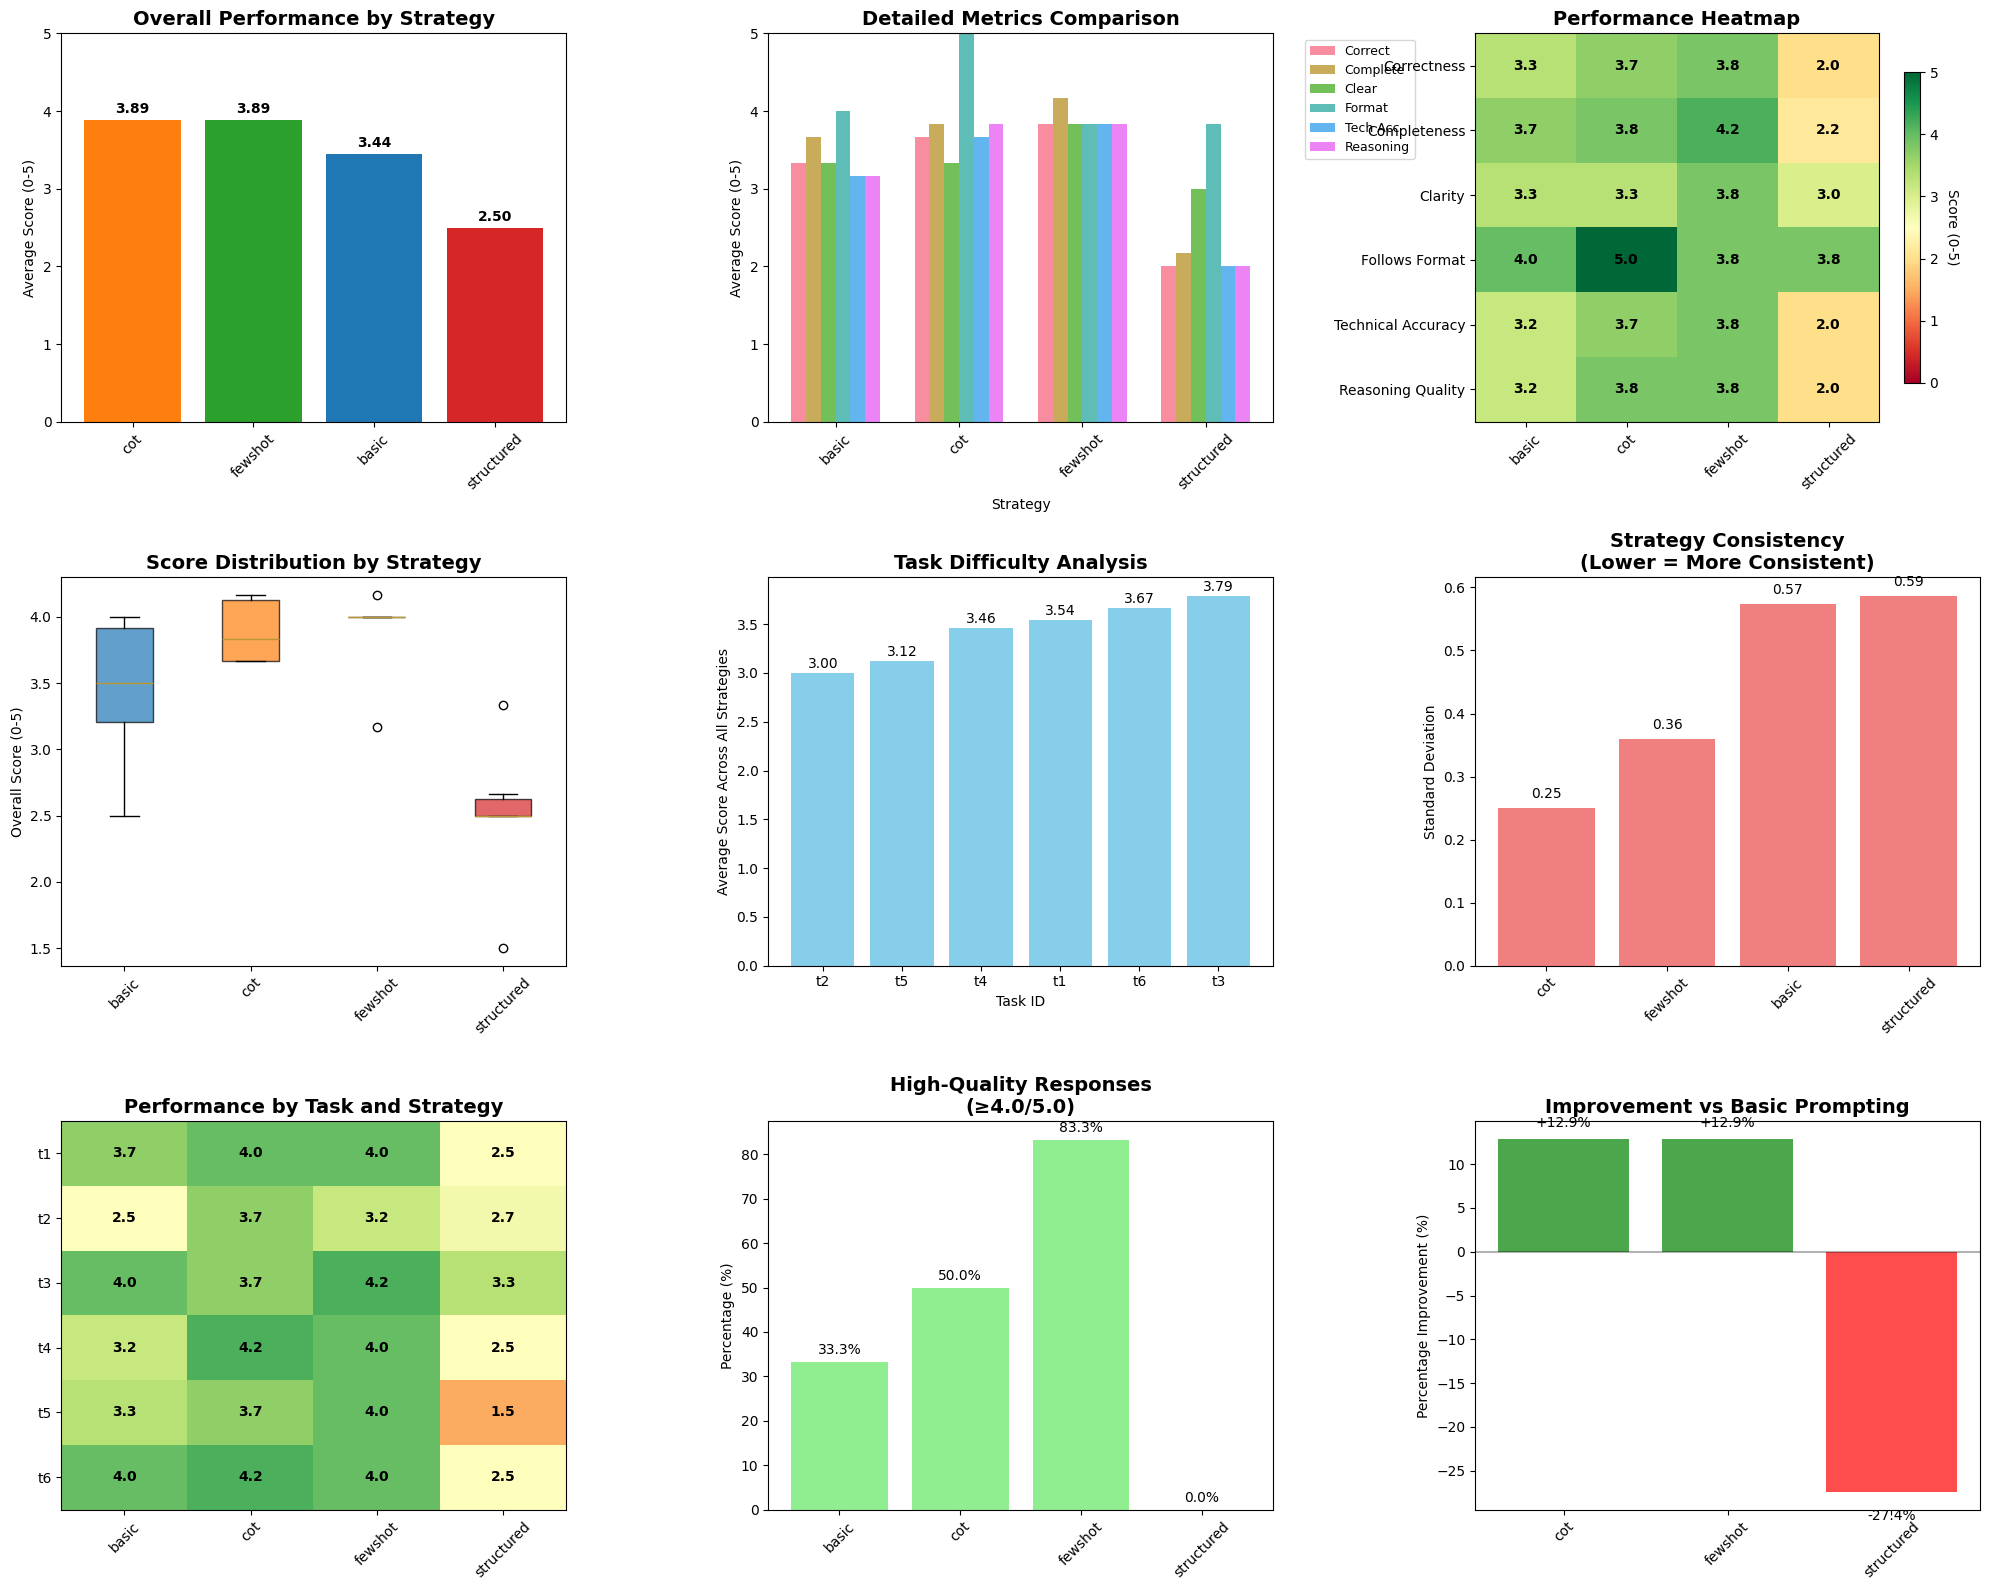

Individual performance chart saved to: a3_outputs/strategy_performance_comparison.png


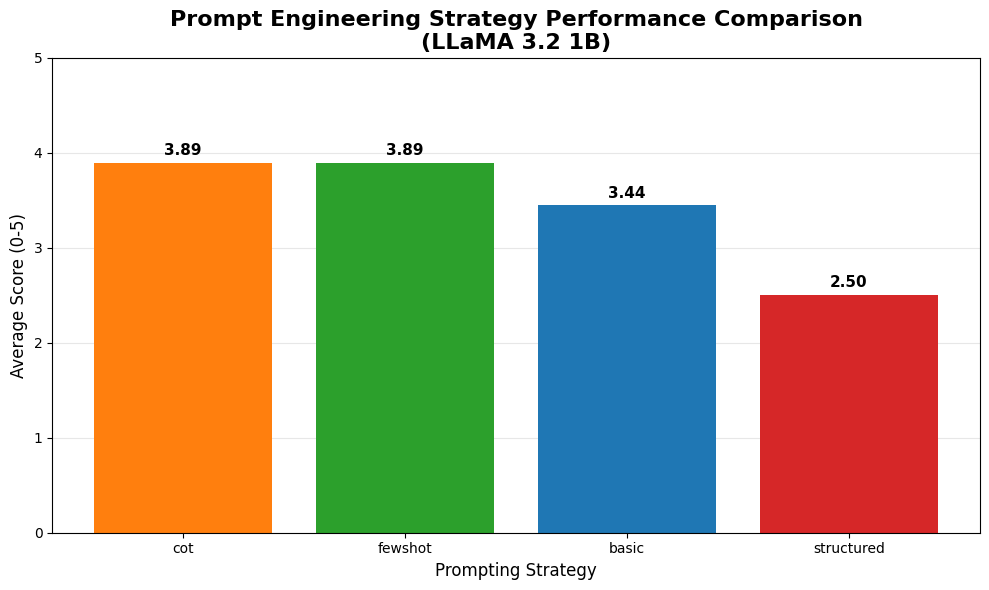


VISUALIZATION SUMMARY

Summary Statistics Table:
  Strategy Overall Score    Best Metric Best Score Consistency (StdDev) High Quality %
     basic          3.44 follows_format       4.00                 0.57          33.3%
       cot          3.89 follows_format       5.00                 0.25          50.0%
   fewshot          3.89   completeness       4.17                 0.36          83.3%
structured          2.50 follows_format       3.83                 0.59           0.0%

Summary table saved to: a3_outputs/visualization_summary_table.csv

Visualization complete! Generated files:
📊 a3_outputs/comprehensive_analysis_dashboard.png
📈 a3_outputs/strategy_performance_comparison.png
📋 a3_outputs/visualization_summary_table.csv


In [15]:
"""
Step 8: Visualization Generation
Create comprehensive charts from your manually scored data
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# ============================================================================
# Load Your Scored Data
# ============================================================================

RESULTS_DIR = "a3_outputs"
scoring_file = os.path.join(RESULTS_DIR, "scoring_template.csv")

print("Loading your manually scored data for visualization...")
df_scored = pd.read_csv(scoring_file)

# Define scoring columns
score_columns = [
    'correctness_0_5',
    'completeness_0_5', 
    'clarity_0_5',
    'follows_format_0_5',
    'technical_accuracy_0_5',
    'reasoning_quality_0_5'
]

# Calculate overall scores
df_scored['overall_score'] = df_scored[score_columns].mean(axis=1)

# Calculate means for plotting
strategy_means = df_scored.groupby('step')[score_columns].mean()

print(f"Creating visualizations for {len(df_scored)} responses across {len(df_scored['step'].unique())} strategies...")

# ============================================================================
# Create Comprehensive Visualization Dashboard
# ============================================================================

# Create a large figure with multiple subplots
fig = plt.figure(figsize=(20, 16))

# Define color palette for consistency
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red
strategy_colors = dict(zip(strategy_means.index, colors))

# ============================================================================
# Plot 1: Overall Performance Comparison (Bar Chart)
# ============================================================================

ax1 = plt.subplot(3, 3, 1)
overall_scores = df_scored.groupby('step')['overall_score'].mean().sort_values(ascending=False)
bars = ax1.bar(overall_scores.index, overall_scores.values, 
               color=[strategy_colors[s] for s in overall_scores.index])
ax1.set_title('Overall Performance by Strategy', fontsize=14, fontweight='bold')
ax1.set_ylabel('Average Score (0-5)')
ax1.set_ylim(0, 5)

# Add value labels on bars
for bar, value in zip(bars, overall_scores.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

ax1.tick_params(axis='x', rotation=45)

# ============================================================================
# Plot 2: Detailed Metrics Comparison (Grouped Bar Chart)
# ============================================================================

ax2 = plt.subplot(3, 3, 2)
x = np.arange(len(strategy_means.index))
width = 0.12
metrics_short = ['Correct', 'Complete', 'Clear', 'Format', 'Tech Acc', 'Reasoning']

for i, (metric, short_name) in enumerate(zip(score_columns, metrics_short)):
    offset = (i - len(score_columns)/2 + 0.5) * width
    bars = ax2.bar(x + offset, strategy_means[metric], width, 
                   label=short_name, alpha=0.8)

ax2.set_title('Detailed Metrics Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Average Score (0-5)')
ax2.set_xlabel('Strategy')
ax2.set_xticks(x)
ax2.set_xticklabels(strategy_means.index, rotation=45)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax2.set_ylim(0, 5)

# ============================================================================
# Plot 3: Performance Heatmap
# ============================================================================

ax3 = plt.subplot(3, 3, 3)
heatmap_data = strategy_means.T  # Transpose for better display
im = ax3.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=5)

# Set ticks and labels
ax3.set_xticks(range(len(strategy_means.index)))
ax3.set_xticklabels(strategy_means.index, rotation=45)
ax3.set_yticks(range(len(score_columns)))
ax3.set_yticklabels([col.replace('_0_5', '').replace('_', ' ').title() for col in score_columns])
ax3.set_title('Performance Heatmap', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(len(score_columns)):
    for j in range(len(strategy_means.index)):
        text = ax3.text(j, i, f'{heatmap_data.iloc[i, j]:.1f}', 
                       ha="center", va="center", color="black", fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax3, shrink=0.8)
cbar.set_label('Score (0-5)', rotation=270, labelpad=15)

# ============================================================================
# Plot 4: Score Distribution (Box Plot)
# ============================================================================

ax4 = plt.subplot(3, 3, 4)
box_data = [df_scored[df_scored['step'] == strategy]['overall_score'].values 
           for strategy in strategy_means.index]
box_plot = ax4.boxplot(box_data, labels=strategy_means.index, patch_artist=True)

# Color the boxes
for patch, strategy in zip(box_plot['boxes'], strategy_means.index):
    patch.set_facecolor(strategy_colors[strategy])
    patch.set_alpha(0.7)

ax4.set_title('Score Distribution by Strategy', fontsize=14, fontweight='bold')
ax4.set_ylabel('Overall Score (0-5)')
ax4.tick_params(axis='x', rotation=45)

# ============================================================================
# Plot 5: Task Difficulty Analysis
# ============================================================================

ax5 = plt.subplot(3, 3, 5)
task_scores = df_scored.groupby('task_id')['overall_score'].mean().sort_values()
bars = ax5.bar(task_scores.index, task_scores.values, color='skyblue')
ax5.set_title('Task Difficulty Analysis', fontsize=14, fontweight='bold')
ax5.set_ylabel('Average Score Across All Strategies')
ax5.set_xlabel('Task ID')

# Add value labels
for bar, value in zip(bars, task_scores.values):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{value:.2f}', ha='center', va='bottom')

# ============================================================================
# Plot 6: Strategy Consistency (Standard Deviation)
# ============================================================================

ax6 = plt.subplot(3, 3, 6)
consistency = df_scored.groupby('step')['overall_score'].std().sort_values()
bars = ax6.bar(consistency.index, consistency.values, color='lightcoral')
ax6.set_title('Strategy Consistency\n(Lower = More Consistent)', fontsize=14, fontweight='bold')
ax6.set_ylabel('Standard Deviation')
ax6.tick_params(axis='x', rotation=45)

# Add value labels
for bar, value in zip(bars, consistency.values):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.2f}', ha='center', va='bottom')

# ============================================================================
# Plot 7: Performance by Task and Strategy (Heatmap)
# ============================================================================

ax7 = plt.subplot(3, 3, 7)
task_strategy_performance = df_scored.pivot(index='task_id', columns='step', values='overall_score')
im2 = ax7.imshow(task_strategy_performance, cmap='RdYlGn', aspect='auto', vmin=0, vmax=5)

ax7.set_xticks(range(len(task_strategy_performance.columns)))
ax7.set_xticklabels(task_strategy_performance.columns, rotation=45)
ax7.set_yticks(range(len(task_strategy_performance.index)))
ax7.set_yticklabels(task_strategy_performance.index)
ax7.set_title('Performance by Task and Strategy', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(len(task_strategy_performance.index)):
    for j in range(len(task_strategy_performance.columns)):
        value = task_strategy_performance.iloc[i, j]
        if not pd.isna(value):
            text = ax7.text(j, i, f'{value:.1f}', 
                           ha="center", va="center", color="black", fontweight='bold')

# ============================================================================
# Plot 8: Quality Threshold Analysis
# ============================================================================

ax8 = plt.subplot(3, 3, 8)
high_quality_counts = df_scored.groupby('step').apply(
    lambda x: (x['overall_score'] >= 4.0).sum()
)
total_counts = df_scored.groupby('step').size()
quality_percentages = (high_quality_counts / total_counts * 100)

bars = ax8.bar(quality_percentages.index, quality_percentages.values, color='lightgreen')
ax8.set_title('High-Quality Responses\n(≥4.0/5.0)', fontsize=14, fontweight='bold')
ax8.set_ylabel('Percentage (%)')
ax8.tick_params(axis='x', rotation=45)

# Add value labels
for bar, value in zip(bars, quality_percentages.values):
    ax8.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{value:.1f}%', ha='center', va='bottom')

# ============================================================================
# Plot 9: Improvement vs Baseline
# ============================================================================

ax9 = plt.subplot(3, 3, 9)
if 'basic' in strategy_means.index:
    baseline = strategy_means.loc['basic'].mean()
    improvements = {}
    for strategy in strategy_means.index:
        if strategy != 'basic':
            strategy_avg = strategy_means.loc[strategy].mean()
            improvement = ((strategy_avg - baseline) / baseline) * 100
            improvements[strategy] = improvement
    
    improvement_series = pd.Series(improvements)
    colors_imp = ['green' if x > 0 else 'red' for x in improvement_series.values]
    bars = ax9.bar(improvement_series.index, improvement_series.values, color=colors_imp, alpha=0.7)
    ax9.set_title('Improvement vs Basic Prompting', fontsize=14, fontweight='bold')
    ax9.set_ylabel('Percentage Improvement (%)')
    ax9.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax9.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, value in zip(bars, improvement_series.values):
        ax9.text(bar.get_x() + bar.get_width()/2, 
                bar.get_height() + (1 if value > 0 else -2), 
                f'{value:+.1f}%', ha='center', 
                va='bottom' if value > 0 else 'top')

# ============================================================================
# Adjust Layout and Save
# ============================================================================

plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Save the comprehensive visualization
viz_path = os.path.join(RESULTS_DIR, 'comprehensive_analysis_dashboard.png')
plt.savefig(viz_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Comprehensive dashboard saved to: {viz_path}")

plt.show()

# ============================================================================
# Create Individual Focused Charts
# ============================================================================

# Individual Chart 1: Clean Performance Comparison
fig2, ax = plt.subplots(figsize=(10, 6))
overall_scores = df_scored.groupby('step')['overall_score'].mean().sort_values(ascending=False)
bars = ax.bar(overall_scores.index, overall_scores.values, 
              color=[strategy_colors[s] for s in overall_scores.index])

ax.set_title('Prompt Engineering Strategy Performance Comparison\n(LLaMA 3.2 1B)', 
             fontsize=16, fontweight='bold')
ax.set_ylabel('Average Score (0-5)', fontsize=12)
ax.set_xlabel('Prompting Strategy', fontsize=12)
ax.set_ylim(0, 5)

# Add value labels
for bar, value in zip(bars, overall_scores.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Add grid for easier reading
ax.grid(True, alpha=0.3, axis='y')
ax.set_axisbelow(True)

plt.tight_layout()
individual_viz_path = os.path.join(RESULTS_DIR, 'strategy_performance_comparison.png')
plt.savefig(individual_viz_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Individual performance chart saved to: {individual_viz_path}")

plt.show()

# ============================================================================
# Generate Summary Statistics Table
# ============================================================================

print("\n" + "="*60)
print("VISUALIZATION SUMMARY")
print("="*60)

# Create summary table
summary_stats = pd.DataFrame({
    'Strategy': strategy_means.index,
    'Overall Score': [f"{df_scored.groupby('step')['overall_score'].mean()[s]:.2f}" for s in strategy_means.index],
    'Best Metric': [strategy_means.loc[s].idxmax().replace('_0_5', '') for s in strategy_means.index],
    'Best Score': [f"{strategy_means.loc[s].max():.2f}" for s in strategy_means.index],
    'Consistency (StdDev)': [f"{df_scored.groupby('step')['overall_score'].std()[s]:.2f}" for s in strategy_means.index],
    'High Quality %': [f"{(df_scored[df_scored['step']==s]['overall_score'] >= 4.0).mean()*100:.1f}%" for s in strategy_means.index]
})

print("\nSummary Statistics Table:")
print(summary_stats.to_string(index=False))

# Save summary table
summary_path = os.path.join(RESULTS_DIR, "visualization_summary_table.csv")
summary_stats.to_csv(summary_path, index=False)
print(f"\nSummary table saved to: {summary_path}")

print(f"\nVisualization complete! Generated files:")
print(f"📊 {viz_path}")
print(f"📈 {individual_viz_path}")
print(f"📋 {summary_path}")